# Supervised Learning: Regression

#### Learning Objectives
- Define linear regression.
- Build a linear regression model using a data set
- Learn a method for finding the best fitting model

<a id="overview-of-supervised-learning"></a>
## Overview of Supervised Learning
---

![Supervised learning diagram](./assets/supervised_learning.png)

## What is a Model?

A Model in our context is an artifact created by the machine learning process one might even consider a program in its own right. The model will accept data and return the appropriate output. 

The overall process looks like this:

1. Form a question we want to test/explore in the form of "Can I predict y with X features?"

2. Load, clean and transform relevant data

3. Identify relevant features/variables for both the question and the model

4. Build a process with an appropriate machine learning algorithm that suits your data, use case, and available computational resources

5. Test, evaluate and refine your model. Often, you'll need to iterate on the model to get the best output

6. Deploy the model - Batch processing or live endpoint (we won't cover this in the class)

7. Monitor and refine the model over time


The end result is a clear and defined process to accept raw information and create predictive or prosciptive insights to your organization.

<a id="introduce-the-bikeshare-dataset"></a>
## Introduce the Bikeshare Data Set
---

We'll be working with a data set from Capital Bikeshare that was used in a Kaggle competition ([data dictionary](https://www.kaggle.com/c/bike-sharing-demand/data)).

The objective of the competition is to **predict total ridership of Capital Bikeshare in any given hour.**

Demand forecasting is a common data science application. If we can predict the quantity of demand, total ridership in a given hour, we can create analytical tools to improve the bikeshare system. 
Some applications would be:
* Find where to site new bikeshare stations and know how large of a station to build.
* Calculate the expected wear and tear on bikes and what the replacement costs will be.
* Use a slightly different research design to forecast full and empty stations and send a service vehicle to "rebalance" the bikes from one station to another, as sometimes bikeshare stations have no bikes or are completely full and prevent use of the station.

In [8]:
# !pip install seaborn

In [61]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 14
plt.style.use("fivethirtyeight")

<a id="read-in-the--capital-bikeshare-data"></a>
### Read In the Capital Bikeshare Data

In [62]:
# Read the data and set the datetime as the index.
url = './data/bikeshare.csv'
bikes = pd.read_csv(url, index_col='datetime', parse_dates=True)

In [63]:
# Preview the first five rows of the DataFrame.
bikes.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
datetime,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


#### What does each observation represent?

In [64]:
# A:

#### What is the response variable (as defined by Kaggle)?

In [65]:
# A:

#### How many features are there?

In [66]:
# A:

See any issues with column names?

| Variable| Description |
|---------|----------------|
|datetime| hourly date + timestamp  |
|season|  1=winter, 2=spring, 3=summer, 4=fall |
|holiday| whether the day is considered a holiday|
|workingday| whether the day is neither a weekend nor holiday|
|weather| 1=Clear, 2=Partly cloudy, 3=Light rain or snow, 4=Heavy rain, snow, storms|
|temp| temperature in Celsius|
|atemp| "feels like" temperature in Celsius|
|humidity| relative humidity|
|windspeed| wind speed|
|casual| number of non-registered user rentals initiated|
|registered| number of registered user rentals initiated|
|**count**| number of total rentals|

In [67]:
# Use the .rename() method to rename count to total
bikes.rename(columns={'count':'total_rentals'}, inplace=True)

<a id="visualizing-the-data"></a>
### Visualizing the Data

When building a model, it's important to have or gain as much background knowledge or business context as you can to the problem you're trying to solve. Visualizing your data can help with this and may also surprise your intuition about the relationships to the response variable.

**View the distribution of total rentals**

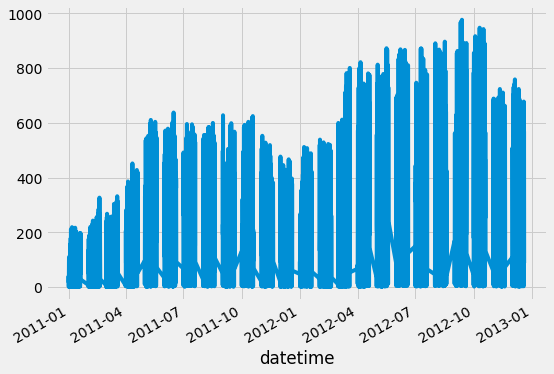

In [68]:
bikes.total_rentals.plot();

**View variable correlations**

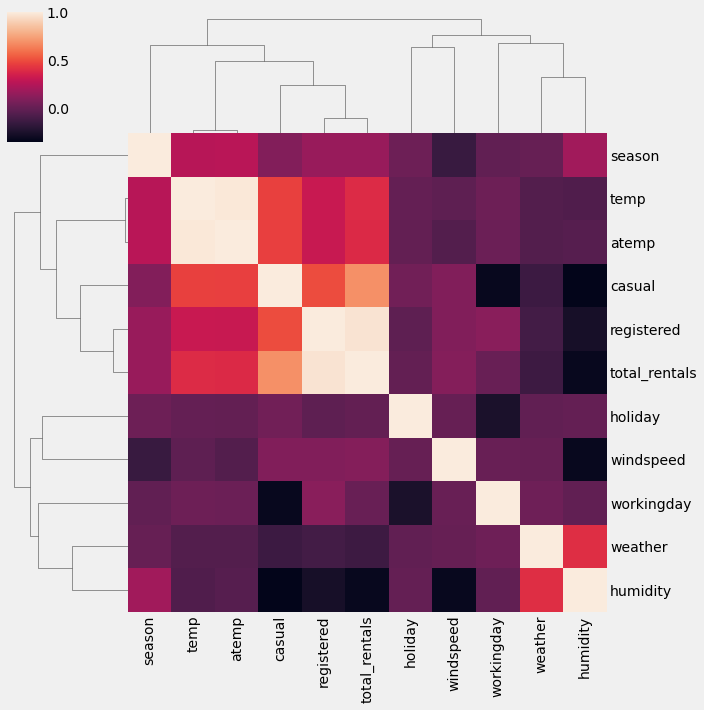

In [69]:
sns.clustermap(bikes.corr());

**Variable relationships**

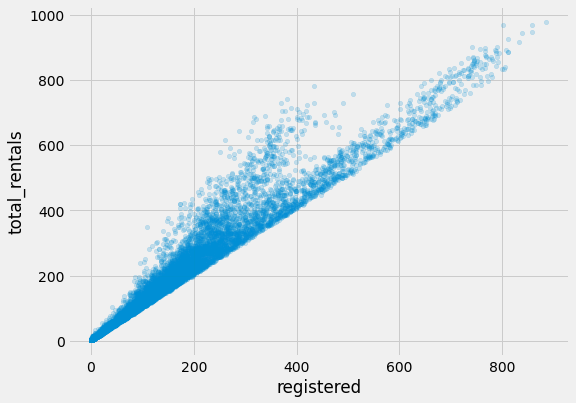

In [70]:
# Pandas scatterplot
bikes.plot(kind='scatter', x='registered', y='total_rentals', alpha=0.2);

#### Classroom Discussion
What is wrong with using `registered` as a variable in the model?

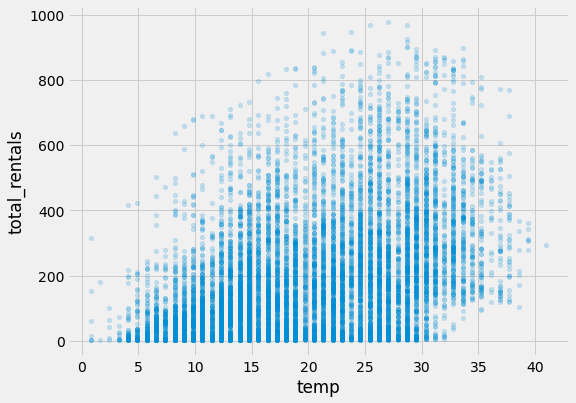

In [71]:
# Pandas scatterplot
bikes.plot(kind='scatter', x='temp', y='total_rentals', alpha=0.2);

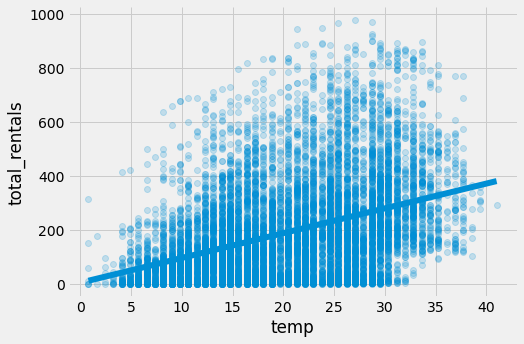

In [72]:
# Seaborn scatterplot with regression line
sns.lmplot(x='temp', y='total_rentals', data=bikes, aspect=1.5, scatter_kws={'alpha':0.2});

<a id="linear-regression-basics"></a>
## Linear Regression Basics
---

 

Key assumptions:

1. Linear relationship between target and features
2. Data is normally distributed or contains Multivariate normality (but doesn't have to be)
3. No or little multicollinearity
4. No auto-correlation
5. Homoscedasticity
6. Independent features

Note: If data is not normally distributed, we could be introducing bias

**1. Linear Relationship** 

First, linear regression needs the relationship between the independent and dependent variables to be linear.  It is also important to check for outliers since linear regression is sensitive to outlier effects.  The linearity assumption can best be tested with scatter plots

**2. Normal Distribution**

Since the linear regression analysis requires all variables to be multivariate normal it can be checked with a histogram or Q-Q plot. When the data is not normally distributed it's possible a non-linear transformation (e.g., log-transformation) might fix this issue.

**3. Low to No Multicollinearity**

Multicollinearity occurs when the independent variables are too highly correlated with each other. A quick way to test this is our tried and true correlation matrix. 

**4. Low to No Auto-correlation**

Linear regression analysis requires that there is little or no autocorrelation in the data.  Autocorrelation occurs when the residuals are not independent from each other.  In other words when the value of y(x+1) is not independent from the value of y(x). Examples are signal processing or time series data


**5. Homoscedasticity**

Homoscedastic data means the residuals are equal across the regression line. We can test this with scatterplots or seaborn's lmplot()

**6. Independent features**

Independent features are in no way derived from other features. Otherwise, we have a problem when interpreting the model since we expect to interpret our outputs as X increase in feature A drives an increase of Y units of the response variable. However, if features are correlated, you lose the ability to interpret the linear regression model because you violate a fundamental assumption.



<a id="form-of-linear-regression"></a>
### Form of Linear Regression

Recall that each model always contains some amount of random irreducible error $\epsilon$. So, given a prediction $\hat{y}$, the actual $y = \hat{y} + \epsilon$. Below, we will assume $y$ is exactly linear.

- We are often taught the formula for a line is: $y = mx + b$.
- Note this can alternatively be written: $y = \alpha + \beta X$.

---

Here, we will generalize this to $n$ independent variables as follows:

$y = \beta_0 + \beta_1x_1 + \beta_2x_2 + ... + \beta_nx_n + \epsilon$

- $y$ is the response.
- $\beta_0$ is the intercept.
- $\beta_1$ is the coefficient for $x_1$ (the first feature).
- $\beta_n$ is the coefficient for $x_n$ (the nth feature).
- $\epsilon$ is the _error_ term

A practical example of this applied to our data might be:

$total\_rides = 20 + -2 \cdot temp + -3 \cdot windspeed\ +\ ...\ +\ 0.1 \cdot registered$

This equation is still called **linear** because the highest degree of the independent variables (e.g. $x_i$) is 1. Note that because the $\beta$ values are constants, they will not be independent variables in the final model, as seen above.

---

The $\beta$ values are called the **model coefficients**:

- These values are estimated (or "learned") during the model fitting process using the **least squares criterion**.
- Specifically, we are trying to find the line (mathematically) that minimizes the **sum of squared residuals** (or "sum of squared errors").
- Once we've learned these coefficients, we can use the model to predict the response.

![Estimating coefficients](./assets/estimating_coefficients.png)

In the diagram above:

- The black dots are the **observed values** of x and y.
- The blue line is our **least squares line**.
- The red lines are the **residuals**, which are the vertical distances between the observed values and the least squares line.

<a id="building-a-linear-regression-model-in-sklearn"></a>
### Building a Linear Regression Model in sklearn

#### Create a feature matrix called X that holds a `DataFrame` with only the temp variable and a `Series` called y that has the "total_rentals" column.

In [73]:
# Create X and y.
feature_cols = ['temp']
X = bikes[feature_cols]
y = bikes.total_rentals

In [74]:
# Check X's type.
print((type(X)))
print((type(X.values)))

<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>


In [75]:
# Check y's type.
print((type(y)))
print((type(y.values)))

<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>


In [76]:
# Check X's shape (n = number of observations, p = number of features).
print((X.shape))

(10886, 1)


In [77]:
# Check y's shape (single dimension with length n).
# The comma indicates the datatype is a tuple.
print((y.shape))

(10886,)


<a id="scikit-learns--step-modeling-pattern"></a>
### scikit-learn's Four-Step Modeling Pattern

**Step 1:** Import the class you plan to use. <br> 
**Step 2:** "Instantiate" the "estimator." <br>
**Step 3:** Fit the model with data (aka "model training"). <br>
**Step 4:** Predict the response for a new observation. <br>
<br>
<br>
<br>
**Step 1:** Import the class you plan to use.

In [78]:
from sklearn.linear_model import LinearRegression

**Step 2:** "Instantiate" the "estimator."

- "Estimator" is scikit-learn's term for "model."

In [79]:
# Make an instance of a LinearRegression object.
lr = LinearRegression()
type(lr)

sklearn.linear_model._base.LinearRegression

To view the possible parameters, either use the `help` built-in function or evaluate the newly instantiated model, as follows:

In [80]:
# help(lr)
lr

LinearRegression()

**Step 3:** Fit the model with data (aka "model training").

- Model is "learning" the relationship between X and y in our "training data."
- Process through which learning occurs varies by model.
- Occurs in-place.

In [81]:
lr.fit(X, y)

LinearRegression()

In [82]:
# Print the coefficients.
print(lr.intercept_)
print(lr.coef_)

6.046212959616611
[9.17054048]


Interpreting the intercept ($\beta_0$):

- It is the value of $y$ when all independent variables are 0.
- Here, it is the estimated number of rentals when the temperature is 0 degrees Celsius.
- **Note:** It does not always make sense to interpret the intercept. (Why?)

Interpreting the "temp" coefficient ($\beta_1$):

- **Interpretation:** An increase of 1 degree Celcius is _associated with_ increasing the number of total rentals by $\beta_1$.
- Here, a temperature increase of 1 degree Celsius is _associated with_ a rental increase of 9.17 bikes.
- This is not a statement of causation.
- $\beta_1$ would be **negative** if an increase in temperature was associated with a **decrease** in total rentals.
- $\beta_1$ would be **zero** if temperature is not associated with total rentals.

In [83]:
dict(zip(lr.coef_,X.columns))

{9.170540481426247: 'temp'}

**Step 4:** Predict the response for a new observation.

- Uses the information it learned during the model training process.

In [84]:
# Per future warning, one-dimensional arrays must be reshaped using the following.
lr.predict(np.array([0]).reshape(1,-1))

/usr/local/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


array([6.04621296])

Let's ask the model to make two predictions, one when the `temp` is 0 and another when the `temp` is 10. To do this, our feature matrix is always a 2-D array where each row is a list of features. Since we only have a single feature, the temperature, each row will contain only a single value.

In [85]:
X_new = [[0], [10]]
lr.predict(X_new)

/usr/local/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


array([ 6.04621296, 97.75161777])

- Returns a NumPy array, and we keep track of what the numbers "mean."
- Can predict for multiple observations at once.

What we just predicted using our model is, "If the temperature is 0 degrees, the total number of bike rentals will be ~6.046, and if the temperature is 10 degrees the total number of bike rentals will ~97.751."

## General Format for sklearn model classes & methods

#### Generate an instance of an estimator class
estimator = base_models.AnySKLearnObject()
#### Fit your data
estimator.fit(X, y)
#### Score it with the default scoring method (recommended to use the metrics module in the future)
estimator.score(X, y)
#### Predict a new set of data
estimator.predict(new_X)
#### Transform a new X if changes were made to the original X while fitting
estimator.transform(new_X)

- LinearRegression() doesn’t have a transform function

- With this information, we can build a simple process for linear regression.



<a id="build-a-linear-regression-model"></a>
### Exercises

#### 1. Las Vegas Simple Model
We will use a [dataset](https://archive.ics.uci.edu/ml/datasets/Las+Vegas+Strip) of Tripadvisor reviews of Las Vegas hotels from 2015 to build a regression model predicting the customers score.

In [86]:
lv_reviews = pd.read_csv('./data/LasVegasTripAdvisorReviews-Dataset.csv')

In [87]:
lv_reviews.head()

,User country,Nr. reviews,Nr. hotel reviews,Helpful votes,Score,Period of stay,Traveler type,Pool,Gym,Tennis court,Spa,Casino,Free internet,Hotel name,Hotel stars,Nr. rooms,User continent,Member years,Review month,Review weekday
0,USA,11,4,13,5,Dec-Feb,Friends,NO,YES,NO,NO,YES,YES,Circus Circus Hotel & Casino Las Vegas,3,3773.0,North America,9.0,January,Thursday
1,USA,119,21,75,3,Dec-Feb,Business,NO,YES,NO,NO,YES,YES,Circus Circus Hotel & Casino Las Vegas,3,3773.0,North America,3.0,January,Friday
2,USA,36,9,25,5,Mar-May,Families,NO,YES,NO,NO,YES,YES,Circus Circus Hotel & Casino Las Vegas,3,3773.0,North America,2.0,February,Saturday
3,UK,14,7,14,4,Mar-May,Friends,NO,YES,NO,NO,YES,YES,Circus Circus Hotel & Casino Las Vegas,3,3773.0,Europe,6.0,February,Friday
4,Canada,5,5,2,4,Mar-May,Solo,NO,YES,NO,NO,YES,YES,Circus Circus Hotel & Casino Las Vegas,3,3773.0,North America,7.0,March,Tuesday


**Create a correlation clustermap of the variables.**

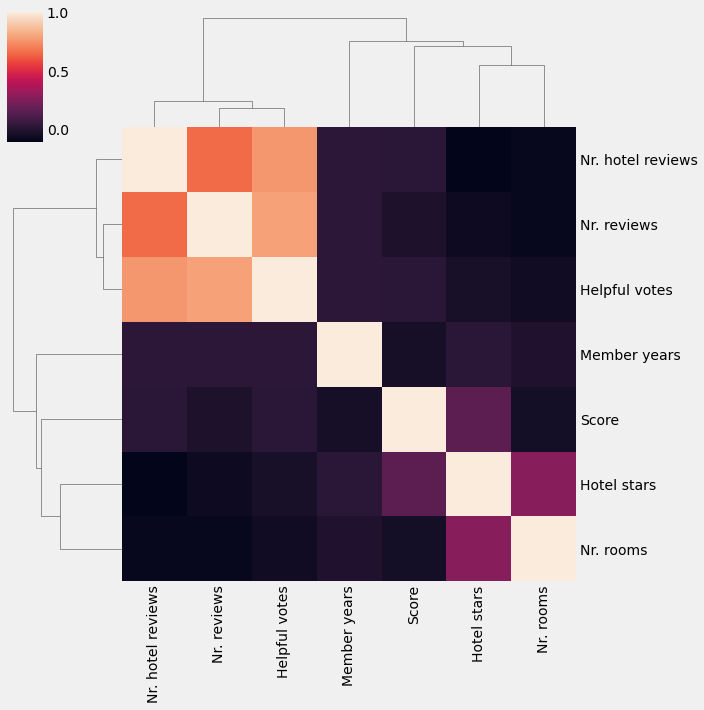

In [88]:
sns.clustermap(lv_reviews.corr());

**View the distribution of the Score variable using a histogram.**

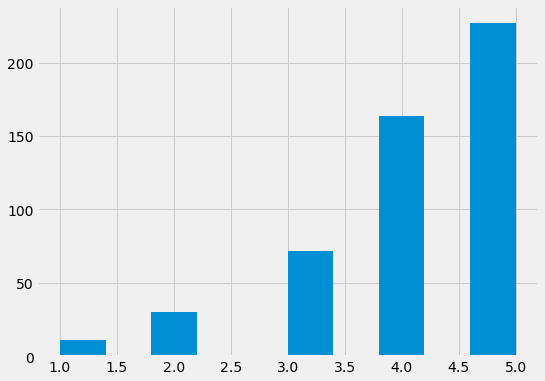

In [89]:
lv_reviews.Score.hist();

**Create X and y using Hotel stars as the X variable and Score as the y variable.**

In [90]:
feature_cols = ['Hotel stars']
X = lv_reviews[feature_cols]
y = lv_reviews.Score

#### Instantiate and fit a `LinearRegression` model on X and y from the `linear_model` section of scikit-learn.

In [91]:
# Import, instantiate, fit.
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
linreg.fit(X, y)

LinearRegression()

**Print the coefficients and intercept.**

In [92]:
print(linreg.intercept_)
print(linreg.coef_)

3.3667728237791925
[0.18683652]


**Interpret the coefficients and intercept.**

In [93]:
# B0: 
# B1: 

<a id="using-the-model-for-prediction"></a>
## Using the Model for Prediction
---


#### How many bike rentals would we predict if the temperature was 25 degrees Celsius?

#### Explore the intercept and coefficients of the linear model.

You can search for "sklearn linear regression" and explore the attributes section of the documentation to learn how to do this.

In [94]:
# Manually calculate the prediction.
linreg.intercept_+linreg.coef_*25
6.04621295961681+9.17054048*25

235.3097249596168

In [95]:
# Use the predict method.
linreg.predict([[25]])

/usr/local/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


array([8.03768577])

**Does the scale of the features matter?** 

No, the scale of the features is irrelevant for linear regression models. When changing the scale, we simply change our interpretation of the coefficients.

<a id="work-with-multiple-features"></a>
## Work With Multiple Features
---

We've demonstrated simple linear regression with one feature to gain an intuition, but the benefit of modeling is the ability to reason about hundreds of features at once (ignoring the curse of dimensionality for the moment)

<a id="visualizing-the-data-part-"></a>
### Visualizing the Data (Part 2)

#### Explore more features.

In [96]:
# Create feature column variables
feature_cols = ['temp', 'season', 'weather', 'humidity']

#### Create a subset of scatterplot matrix using Seaborn.
We can use pairplot with the y_vars argument to only show relationships with the `total_rentals` variable

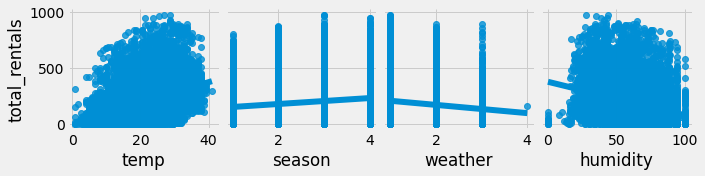

In [97]:
# multiple scatterplots in Seaborn
sns.pairplot(bikes, x_vars=feature_cols, y_vars='total_rentals', kind='reg');

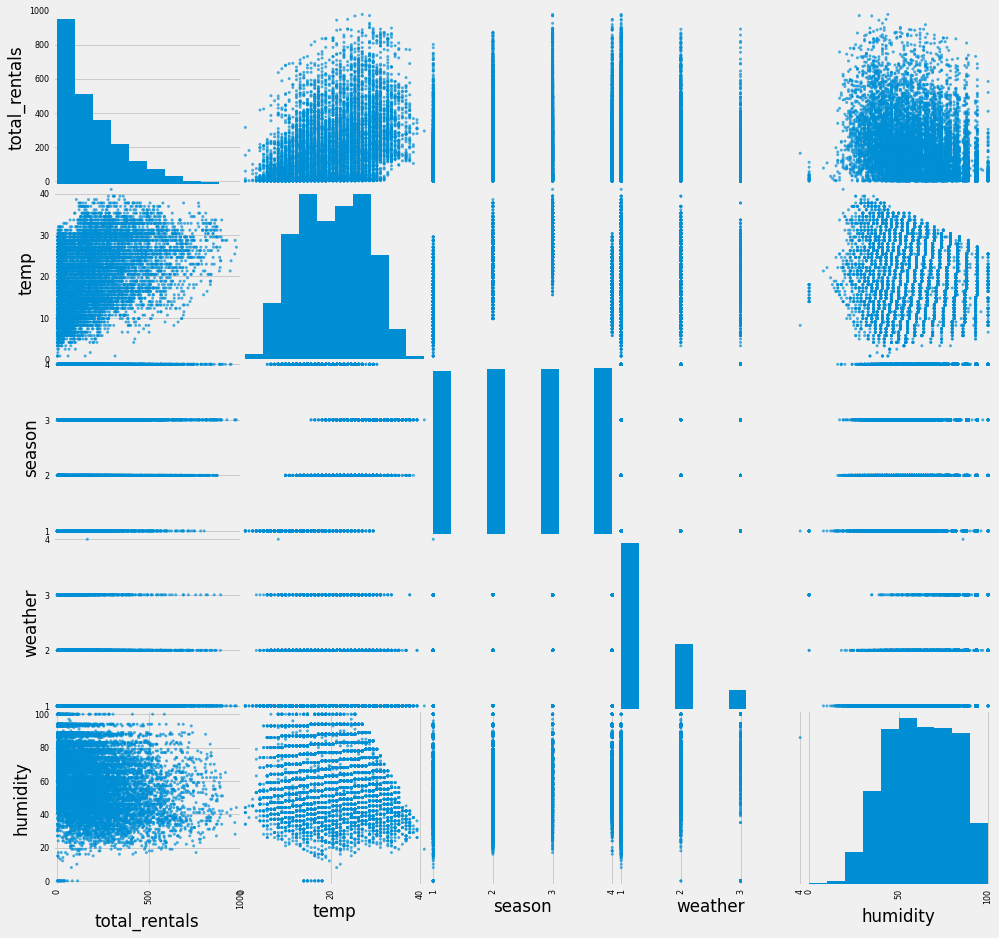

In [98]:
grr = pd.plotting.scatter_matrix(bikes[['total_rentals'] + feature_cols], figsize=(15, 15), alpha=0.7)

#### Are you seeing anything you didn't expect?

#### Explore the season variable using a box plot.

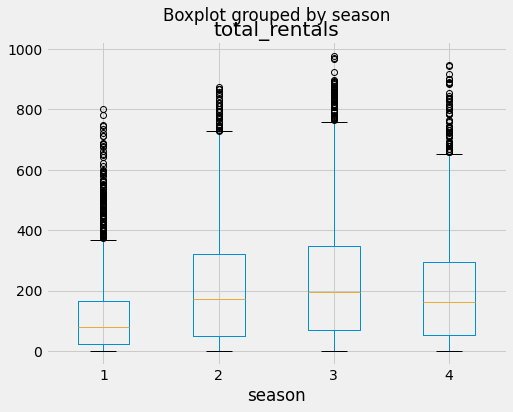

In [99]:
# Box plot of rentals, grouped by season
bikes.boxplot(column='total_rentals', by='season');

#### Look at rentals over time.

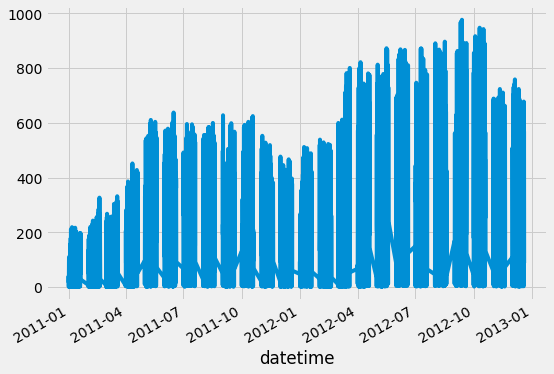

In [100]:
# Line plot of rentals
bikes.total_rentals.plot();

#### What does this tell us?

There are more rentals in the winter than the spring, but only because the system is experiencing overall growth and the winter months happen to come after the spring months.

<a id="adding-more-features-to-the-model"></a>
### Adding More Features to the Model

In the previous example, one variable explained the variance of another; however, more often than not, we will need multiple variables. How many real-world problems can be explained with just one variable? 

#### Create another `LinearRegression` instance that is fit using temp, season, weather, and humidity.

In [101]:
# Create a list of features.
feature_cols = ['temp', 'season', 'weather', 'humidity']

In [102]:
# Create X and y.
X = bikes[feature_cols]
y = bikes.total_rentals

# Instantiate and fit.
linreg = LinearRegression()
linreg.fit(X, y)

# Print the coefficients.
print(linreg.intercept_)
print(linreg.coef_)

159.5206878612979
[ 7.86482499 22.53875753  6.67030204 -3.11887338]


#### Display the linear regression coefficient along with the feature names.

In [103]:
# Pair the feature names with the coefficients.
list(zip(feature_cols, linreg.coef_))

[('temp', 7.86482499247745),
 ('season', 22.538757532466768),
 ('weather', 6.670302035923734),
 ('humidity', -3.118873382396501)]

<a id="what-is-multicollinearity"></a>
## What Is Multicollinearity?
---

Multicollinearity happens when two or more features are highly correlated with each other. The problem is that due to the high correlation, it's hard to disambiguate which feature has what kind of effect on the outcome. In other words, the features mask each other. 

There is a second related issue called variance inflation where including correlated features increases the variability of our model and p-values by widening the standard errors. This can be measured with the variance inflation factor, which we will not cover here.

#### Create a linear model that predicts `total_rentals` using `temp` and `atemp`.

In [104]:
# Create a list of features.
feature_cols = ['temp','atemp']

In [105]:
# Create X and y.
X = bikes[feature_cols]
y = bikes.total_rentals

# Instantiate and fit.
linreg = LinearRegression()
linreg.fit(X, y)

# Print the coefficients.
print(linreg.intercept_)
print(list(zip(feature_cols,linreg.coef_)))

4.2481326458035085
[('temp', 8.198658744678822), ('atemp', 0.907208084465892)]


#### Go back and remove either `temp` or `atemp` from the feature list. How do the coefficients change? 

In [106]:
# A:
#feature_cols = ['temp']
#feature_cols = ['atemp']

### Exercises
#### 2. Las Vegas Multiple Variable Model 
Using the Las Vegas Trip Advisor data, build a model using 2 variables: `Hotel stars` and `Nr. reviews`.

In [107]:
lv_reviews.columns

Index(['User country', 'Nr. reviews', 'Nr. hotel reviews', 'Helpful votes',
       'Score', 'Period of stay', 'Traveler type', 'Pool', 'Gym',
       'Tennis court', 'Spa', 'Casino', 'Free internet', 'Hotel name',
       'Hotel stars', 'Nr. rooms', 'User continent', 'Member years',
       'Review month', 'Review weekday'],
      dtype='object')

In [108]:
# Create a list of features.
feature_cols = ['Hotel stars', 'Nr. reviews']

# Create X and y.
X = lv_reviews[feature_cols]
y = lv_reviews.Score


# Instantiate and fit.
linreg = LinearRegression()
linreg.fit(X, y)

# Print the coefficients.
print(linreg.intercept_)
print(linreg.coef_)

3.3798334137746378
[ 1.85711835e-01 -1.76774045e-04]


In [109]:
# Pair the feature names with the coefficients.
list(zip(feature_cols, linreg.coef_))

[('Hotel stars', 0.1857118354098394), ('Nr. reviews', -0.00017677404478893286)]

**Give your interpretations of the coefficients.**

**What would be your next steps?**

# Transform, Score and compare RMSE.
<a id="how-to-select-a-model"></a>
## How to Select a Model
---

How do we know we have the best model for our application? Here's one way to go about selecting which model is best

<a id="feature-selection"></a>
### Feature Selection

How do we choose which features to include in the model? We're going to use **train/test split** (and eventually **cross-validation**).

Why not use p-values or R-squared for feature selection?

- Linear models rely upon a lot of assumptions (such as the features being independent), and if those assumptions are violated, p-values and R-squared are less reliable. Train/test split relies on fewer assumptions.
- If all of the assumptions of a linear model are met, p-values suggest a coefficient that differs from zero at a level of statistical significance. This does not mean that
    1. the feature _causes_ the response
    2. the feature strongly _predicts_ the response. 
- Adding features to your model that are unrelated to the response will always increase the R-squared value, and adjusted R-squared does not sufficiently account for this (although, AIC and BIC do).
- p-values and R-squared are **proxies** for our goal of generalization, whereas train/test split and cross-validation attempt to directly estimate how well the model will generalize to out-of-sample data.

More generally:

- There are different methodologies that can be used for solving any given data science problem, and this course follows a machine learning methodology.
- This course focuses on general purpose approaches that can be applied to any model, rather than model-specific approaches.

<a id="evaluation-metrics-for-regression-problems"></a>
### Evaluation Metrics for Regression Problems

Evaluation metrics for classification problems, such as accuracy, are not useful for regression problems. We need evaluation metrics designed for comparing continuous values.

Here are three common evaluation metrics for regression problems:

**Mean absolute error (MAE)** is the mean of the absolute value of the errors:

$$\frac 1n\sum_{i=1}^n|y_i-\hat{y}_i|$$

**Mean squared error (MSE)** is the mean of the squared errors:

$$\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2$$

**Root mean squared error (RMSE)** is the square root of the mean of the squared errors:

$$\sqrt{\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2}$$

In [54]:
# Example true and predicted response values
true = [10, 7, 5, 5]
pred = [8, 6, 5, 10]

#### Calculate MAE, MSE, and RMSE using imports from sklearn metrics and NumPy.

In [55]:
# Calculate these metrics by hand!
from sklearn import metrics
import numpy as np
print('MAE:', metrics.mean_absolute_error(true, pred))
print('MSE:', metrics.mean_squared_error(true, pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(true, pred)))

MAE: 2.0
MSE: 7.5
RMSE: 2.7386127875258306


Let's compare these metrics:

- MAE is the easiest to understand, because it's the average error.
- MSE is more popular than MAE, because MSE "punishes" larger errors, which tends to be useful in the real world. Also, MSE is continuous and differentiable, making it easier to use than MAE for optimization.
- RMSE is even more popular than MSE, because RMSE is interpretable in the "y" units.

All of these are **loss functions**, because we want to minimize them.

Here's an additional example, to demonstrate how MSE/RMSE punishes larger errors:

In [56]:
# Same true values as above
true = [10, 7, 5, 5]

# New set of predicted values
pred = [10, 7, 5, 13]

# MAE is the same as before.
print('MAE:', metrics.mean_absolute_error(true, pred))

# MSE and RMSE are larger than before.
print('MSE:', metrics.mean_squared_error(true, pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(true, pred)))

MAE: 2.0
MSE: 16.0
RMSE: 4.0


<a id="comparing-models-with-traintest-split-and-rmse"></a>
### Comparing Models With Train/Test Split and RMSE

![](./assets/Train-Test-Split-CV.png)

In [57]:
from sklearn.model_selection import train_test_split

# Define a function that accepts a list of features and returns testing RMSE.
def train_test_rmse(df, feature_cols, response):
    X = df[feature_cols]
    y = df[response]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)
    
    linreg = LinearRegression()
    linreg.fit(X_train, y_train)
    
    y_pred = linreg.predict(X_test)
    return np.sqrt(metrics.mean_squared_error(y_test, y_pred))

In [58]:
# Compare different sets of features.
print(train_test_rmse(bikes, ['temp', 'season', 'weather', 'humidity'], 'total_rentals'))
print(train_test_rmse(bikes, ['temp', 'season', 'weather'],'total_rentals'))
print(train_test_rmse(bikes, ['temp', 'season', 'humidity'],'total_rentals'))

155.64945913079674
164.1653997629182
155.59818936691417


In [110]:
# Append scores to dataset
X = bikes[['temp', 'season', 'humidity']]
y = bikes['total_rentals']
    
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)
    
linreg = LinearRegression()
linreg.fit(X_train, y_train)

bikes['y_pred']= linreg.predict(X)

In [111]:
bikes.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total_rentals,y_pred
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,17.076739
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,13.512391
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,13.512391
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,35.180885
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,35.180885


In [112]:
# Using these as features is not allowed!
print(train_test_rmse(bikes, ['casual', 'registered'],'total_rentals'))

3.8228183176583084e-14


<a id="comparing-testing-rmse-with-null-rmse"></a>
### Comparing Testing RMSE With Null RMSE

Null RMSE is the RMSE that could be achieved by always predicting the mean response value. It is a benchmark against which you may want to measure your regression model.

In [113]:
from sklearn.dummy import DummyRegressor

# Create X and y.
X = bikes['temp']
y = bikes.total_rentals

# Split X and y into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)

# Create a dummy regressor
dummy_mean = DummyRegressor(strategy='mean')

# "Train" dummy regressor
dummy_mean.fit(X_train, y_train)

DummyRegressor()

In [114]:
#Save Predictions
y_pred_dummy = dummy_mean.predict(X_test)

#Testing MSE
print(metrics.mean_squared_error(y_test, y_pred_dummy))

#Testing RMSE
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred_dummy)))

32249.489445242507
179.58142845306278


### Exercises
#### 3. Las Vegas Model Comparison

**Create a baseline/null model result to compare your models.**

In [115]:
# Create X and y.
X = lv_reviews['Hotel stars']
y = lv_reviews.Score

# Split X and y into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)

# Create a dummy regressor
dummy_mean = DummyRegressor(strategy='mean')

# "Train" dummy regressor
dummy_mean.fit(X_train, y_train)

#Save Predictions
y_pred_dummy = dummy_mean.predict(X_test)

#Testing RMSE
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred_dummy)))

0.9820482112841579


**Compare the single variable and multiple variable models using the `train_test_rmse` function.**

In [116]:
print(train_test_rmse(lv_reviews, ['Hotel stars'], 'Score'))

0.9622026200611421


In [117]:
print(train_test_rmse(lv_reviews, ['Hotel stars','Nr. reviews'], 'Score'))

0.9719813875991448


**Which model is better?**

**Why is the RMSE significantly lower than the RMSE in the bikes model?**

<a id="feature-engineering-to-improve-performance"></a>
## Feature Engineering to Improve Performance
---

Machine learning models are very powerful, but they cannot automatically handle every aspect of our data. We have to explicitly modify our features to have relationships that our models can understand. In this case, we will need to pull out features to have a linear relationship with our response variable.


<a id="handling-categorical-features"></a>
### Handling Categorical Features

scikit-learn expects all features to be numeric. So how do we include a categorical feature in our model?

- **Ordered categories:** Transform them to sensible numeric values (example: small=1, medium=2, large=3)
- **Unordered categories:** Use dummy encoding (0/1). Here, each possible category would become a separate feature.

What are the categorical features in our data set?

- **Ordered categories:** `weather` (already encoded with sensible numeric values)
- **Unordered categories:** `season` (needs dummy encoding), `holiday` (already dummy encoded), `workingday` (already dummy encoded)

For season, we can't simply leave the encoding as 1 = spring, 2 = summer, 3 = fall, and 4 = winter, because that would imply an ordered relationship. Instead, we create multiple dummy variables.

#### Create dummy variables using `get_dummies` from Pandas.

In [122]:
season_dummies = pd.get_dummies(bikes.season, prefix='season')

#### Inspect the `DataFrame` of `dummies`.

In [123]:
# Print five random rows.
season_dummies.sample(n=5, random_state=1)

,season_1,season_2,season_3,season_4
datetime,,,,
2011-09-05 11:00:00,0,0,1,0
2012-03-18 04:00:00,1,0,0,0
2012-10-14 17:00:00,0,0,0,1
2011-04-04 15:00:00,0,1,0,0
2012-12-11 02:00:00,0,0,0,1


However, we actually only need three dummy variables (not four), and thus we'll drop the first dummy variable.

Why? Because three dummies captures all of the "information" about the season feature, and implicitly defines spring (season 1) as the baseline level.

This circles back to the concept multicollinearity, except instead of one feature being highly correlated to another, the information gained from three features is directly correlated to the fourth.

#### Drop the first column.

In [124]:
season_dummies.drop(season_dummies.columns[0], axis=1, inplace=True)

#### Reinspect the `DataFrame` of `dummies`.

In [125]:
# Print five random rows.
season_dummies.sample(n=5, random_state=1)

,season_2,season_3,season_4
datetime,,,
2011-09-05 11:00:00,0,1,0
2012-03-18 04:00:00,0,0,0
2012-10-14 17:00:00,0,0,1
2011-04-04 15:00:00,1,0,0
2012-12-11 02:00:00,0,0,1


In general, if you have a categorical feature with k possible values, you create k-1 dummy variables.

If that's confusing, think about why we only need one dummy variable for `holiday`, not two dummy variables (`holiday_yes` and `holiday_no`).

#### We now need to concatenate the two `DataFrames` together.

In [126]:
# Concatenate the original DataFrame and the dummy DataFrame (axis=0 means rows, axis=1 means columns).
bikes_dummies = pd.concat([bikes, season_dummies], axis=1)

# Print 5 random rows.
bikes_dummies.sample(n=5, random_state=1)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total_rentals,y_pred,season_2,season_3,season_4
datetime,,,,,,,,,,,,,,,
2011-09-05 11:00:00,3,1,0,2,28.70,33.335,74,11.0014,101,207,308,234.757046,0,1,0
2012-03-18 04:00:00,1,0,0,2,17.22,21.210,94,11.0014,6,8,14,37.086439,0,0,0
2012-10-14 17:00:00,4,0,0,1,26.24,31.060,44,12.9980,193,346,539,328.122447,0,0,1
2011-04-04 15:00:00,2,0,1,1,31.16,33.335,23,36.9974,47,96,143,385.797616,1,0,0
2012-12-11 02:00:00,4,0,1,2,16.40,20.455,66,22.0028,0,1,1,182.760112,0,0,1


#### Rerun the linear regression with dummy variables included.

In [127]:
# Include dummy variables for season in the model.
feature_cols = ['temp', 'season_2', 'season_3', 'season_4', 'humidity']
X = bikes_dummies[feature_cols]
y = bikes_dummies.total_rentals

linreg = LinearRegression()
linreg.fit(X, y)

list(zip(feature_cols, linreg.coef_))

[('temp', 11.18640586357579),
 ('season_2', -3.390543099718222),
 ('season_3', -41.736860713170735),
 ('season_4', 64.41596146824212),
 ('humidity', -2.8194816362596473)]

How do we interpret the season coefficients? They are measured against the baseline (spring):

- Holding all other features fixed, summer is associated with a rental decrease of 3.39 bikes compared to the spring.
- Holding all other features fixed, fall is associated with a rental decrease of 41.7 bikes compared to the spring.
- Holding all other features fixed, winter is associated with a rental increase of 64.4 bikes compared to the spring.

Would it matter if we changed which season was defined as the baseline?

- No, it would simply change our interpretation of the coefficients.

In most situations, it is best to have the dummy that is your baseline be the category that has the largest representation.

**Important:** Dummy encoding is relevant for all machine learning models, not just linear regression models.

In [128]:
# Compare original season variable with dummy variables.
print(train_test_rmse(bikes_dummies, ['temp', 'season', 'humidity'],'total_rentals'))
print(train_test_rmse(bikes_dummies, ['temp', 'season_2', 'season_3', 'season_4', 'humidity'],'total_rentals'))

155.59818936691417
154.33394593635998


## Bias & Variance
**Conceptual Definitions**
- **Bias**: How close are predictions to the actual values?
  - **Accuracy.** Roughly, whether or not our model aims on target.
  - If the model cannot represent the data's structure, our predictions could be consistent, but will not be accurate.
- **Variance**: How variable are our predictions?
  - **Precision.** Roughly, whether or not our model is reliable.
  - We will make slightly different predictions given slightly different training sets.
  
![](./assets/biasVsVarianceImage.png)

- Visually, we are building a model where the bulls-eye is the goal.
- Each individual hit is one prediction based on our model.
- Critically, the success of our model **(low variance, low bias)** depends on the training data present.

![Bias-variance tradeoff](./assets/bias_variance.png)

<a id="bonus-material-regularization"></a>
## Regularization
---

- Regularization is a method for "constraining" or "regularizing" the size of the coefficients, thus "shrinking" them toward zero.
- It reduces model variance and thus minimizes overfitting.
- If the model is too complex, it tends to reduce variance more than it increases bias, resulting in a model that is more likely to generalize.

Our goal is to locate the optimum model complexity, and thus regularization is useful when we believe our model is too complex.

<a id="how-does-regularization-work"></a>
### How Does Regularization Work?

For a normal linear regression model, we estimate the coefficients using the least squares criterion, which minimizes the residual sum of squares (RSS).

For a regularized linear regression model, we minimize the sum of RSS and a "penalty term" that penalizes coefficient size.

**Ridge regression** (or "L2 regularization") minimizes: $$\text{RSS} + \alpha \sum_{j=1}^p \beta_j^2$$

**Lasso regression** (or "L1 regularization") minimizes: $$\text{RSS} + \alpha \sum_{j=1}^p |\beta_j|$$

- $p$ is the number of features.
- $\beta_j$ is a model coefficient.
- $\alpha$ is a tuning parameter:
    - A tiny $\alpha$ imposes no penalty on the coefficient size, and is equivalent to a normal linear regression model.
    - Increasing the $\alpha$ penalizes the coefficients and thus shrinks them.

<a id="lasso-and-ridge-path-diagrams"></a>
### Lasso and Ridge Path Diagrams

A larger alpha (toward the left of each diagram) results in more regularization:

- Lasso regression shrinks coefficients all the way to zero, thus removing them from the model.
- Ridge regression shrinks coefficients toward zero, but they rarely reach zero.

Source code for the diagrams: [Lasso regression](http://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_lars.html) and [Ridge regression](http://scikit-learn.org/stable/auto_examples/linear_model/plot_ridge_path.html)

![Lasso and Ridge Coefficient Plots](./assets/lasso_ridge_path.png)

<a id="advice-for-applying-regularization"></a>
### Advice for Applying Regularization

**Should features be standardized?**

- Yes, because otherwise, features would be penalized simply because of their scale.
- Also, standardizing avoids penalizing the intercept, which wouldn't make intuitive sense.

**How should you choose between lasso regression and ridge regression?**

- Lasso regression is preferred if we believe many features are irrelevant or if we prefer a sparse model.
- Ridge can work particularly well if there is a high degree of multicollinearity in your model.
- If model performance is your primary concern, it is best to try both.
- Elastic net regression is a combination of lasso regression and ridge Regression.

<a id="ridge-regression"></a>
### Ridge Regression

- [Ridge](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) documentation
- **alpha:** must be positive, increase for more regularization
- **normalize:** scales the features (without using StandardScaler)

In [129]:
# Include dummy variables for season in the model.
feature_cols = ['temp', 'atemp', 'season_2', 'season_3', 'season_4', 'humidity']

X = bikes_dummies[feature_cols]
y = bikes_dummies.total_rentals

In [130]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [132]:
# alpha=0 is equivalent to linear regression.
from sklearn.linear_model import Ridge

# Instantiate the model.
#(Alpha of zero has no regularization strength, essentially a basic linear regression.)
ridgereg = Ridge(alpha=0)

# Fit the model.
ridgereg.fit(X_train, y_train)

# Predict with fitted model.
y_pred = ridgereg.predict(X_test)
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

156.67429349903927


In [133]:
# Coefficients for a non-regularized linear regression
list(zip(feature_cols, ridgereg.coef_))

[('temp', 8.537530902592902),
 ('atemp', 2.4548540987567447),
 ('season_2', -9.325429567785545),
 ('season_3', -40.67899619746354),
 ('season_4', 61.11748928364946),
 ('humidity', -2.8650448305441625)]

To interpret these coefficients we need to convert them back to original units, which is a reason to do normalization by hand. However, in this form the coefficients have a special meaning. The intercept is now the average of our outcome, and the magnitude of each coefficient in the model is a measure of how important it is in the model. We call this feature importance.

In [135]:
# Try alpha=0.1.
ridgereg = Ridge(alpha=0.1)
ridgereg.fit(X_train, y_train)
y_pred = ridgereg.predict(X_test)
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

156.67432893092197


In [136]:
# Examine the coefficients.
list(zip(feature_cols, ridgereg.coef_))

[('temp', 8.536965568744755),
 ('atemp', 2.4551059359839305),
 ('season_2', -9.322609400813553),
 ('season_3', -40.67269881073377),
 ('season_4', 61.11512032209006),
 ('humidity', -2.865055815778278)]

While the MSE barely changed, we can see there are significant changes in the weight of our coefficients.  Particularly `season_2` whose coefficient has greatly decreased toward 0.

Fitting and using a Lasso Regression in scikit-learn is very similar.  

In addition to the typical [lasso](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) and [ridge](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) there is a third type of regression, [Elastic Net](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html) which combines the penalties of the ridge and lasso methods.

<a id="comparing-linear-regression-with-other-models"></a>
## Comparing Linear Regression With Other Models

Advantages of linear regression:

- Simple to explain.
- Highly interpretable.
- Model training and prediction are fast.
- No tuning is required (excluding regularization).
- Features don't need scaling.
- Can perform well with a small number of observations.
- Well understood.

Disadvantages of linear regression:

- Presumes a linear relationship between the features and the response.
- Performance is (generally) not competitive with the best supervised learning methods due to high bias.
- Can't automatically learn feature interactions.